1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

2. Define functions to load data, create features

In [2]:
def create_features(df):
    df['Spread'] = df['High'] - df['Low']
    df['Gap'] = df['Open'] - df['Close'].shift(1)
    df['Intraday'] = df['Open'] - df['Close']
    return df

def drop_features(df):
    df.drop(columns=['Spread',
                     'Gap',
                     'Intraday',
                     ],
            inplace=True)

    df.drop(columns=['Open','High','Low','Close','Volume','Adj Close',
                     ], inplace=True)
    return df

def process_features(df, lookback, step):
    for i in range(step, lookback+1, step):
        df['%d Spread' % (i)] = df['Spread'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Spread' % (i)] = df['Spread'].rolling(window=i).mean()

        df['%d Gap' % (i)] = df['Gap'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Gap' % (i)] = df['Gap'].rolling(window=i).mean()

        df['%d Intraday' % (i)] = df['Intraday'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Intraday' % (i)] = df['Intraday'].rolling(window=i).mean()
    return df

def features(df, lookback, step):
    newDf = df.copy()
    create_features(newDf)
    process_features(newDf, lookback, step)
    drop_features(newDf)
    return newDf

3. Create a function to create a target.

In [3]:
def create_target(df, lookforward=1, target='Close'):
    df['Target'] = df[target].pct_change(lookforward).shift(-lookforward)
    return df

4. Create a custom scoring function.

In [4]:
def custom_score(y_true, y_pred):
  pred_sign = np.sign(y_pred)
  y_true = np.squeeze(y_true)
  returns = np.where((pred_sign == 1), y_true, 0)
  returns = np.where((pred_sign == -1), y_true * -1, returns)
  return returns.mean()

custom_scorer = make_scorer(custom_score, greater_is_better=True)

With this scoring function, we are scoring different models on their average returns, as opposed to the normal scoring function of a regression model, which would be R^2 or RMSE, both of which are fine if we were predicting price, but accurately predicting price =/= good returns. So instead we just score the models directly on their average returns.

5. Define the models we are going to use

In [5]:
estimator1 = Ridge()
estimator2 = Lasso(alpha=.001)
estimator3 = LGBMRegressor(max_depth=3, num_leaves=2**3, random_state=0, linear_tree=True)
estimator4 = MLPRegressor(solver='adam', activation='relu', random_state=0, shuffle=False, hidden_layer_sizes=(16, 16, 16))
models = [estimator1,estimator2,estimator3,estimator4]
estimator = VotingRegressor(estimators=[('Ridge', estimator1),
                                        ('Lasso', estimator2),
                                        ('LGBM', estimator3),
                                        ('NN', estimator4),
                                        ])

We combine the 3 models into 1 using the VotingRegressor. The VotingRegressor works by averaging the output of the models that its composed of into a single output. Go to this link for more info: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html

6. Define target, cross validation folds, interval, and lookback parameters.

In [6]:
lookforward = 1
tscv = TimeSeriesSplit(n_splits=5, gap=lookforward)
steps = np.arange(1, 21+1, 1)
lookbacks = np.arange(1, 21+1, 1)
cv_results = pd.DataFrame(columns=['step', 'lookback', 'score'])

To make sure the strategy our models come up with are actually significant, and not just a memorization of the data we gave it, we test the model 5 times (n_splits=5). We also have to add a gap between each split, otherwise there will be some overlap, which could cause the models to peek at data it shouldn't, and artificially inflate its score. Next we define the steps (or intervals) and lookbacks we want to test our model at, in order to find the ones that it scores the highest on. Lastly, we create an object to store the results of our model in.

7. Evaluate and visualize scores of different combinations of parameters

In [7]:
# create a function that downloads data, creates features, and merges them into a single dataframe
spy = yf.download('SPY', start='2004-12-01')
agg = yf.download('AGG', start='2004-12-01')
gld = yf.download('GLD', start='2004-12-01')
spy = create_target(spy, lookforward, target='Close')

def create_df(spy, agg, gld, lookback, step):
    SPY = features(spy, lookback, step)
    SPY = SPY.add_suffix(' SPY')
    AGG = features(agg, lookback, step)
    AGG = AGG.add_suffix(' AGG')
    GLD = features(gld, lookback, step)
    GLD = GLD.add_suffix(' GLD')
    df = pd.concat([SPY, AGG, GLD], axis=1)
    return df

for step in steps:
    for lookback in lookbacks:
        if lookback >= step:

            cv = create_df(spy, agg, gld, lookback, step)

            cv.drop(cv.tail(lookforward).index, inplace=True)
            cv.drop(cv.head(max(lookbacks)).index, inplace=True)

            X = cv
            y = X[['Target SPY']]
            # make one dimensional
            y = y.values.ravel()
            X = X.drop(columns=['Target SPY'])
            X.fillna(method="ffill", inplace=True)
            X.replace([np.inf, -np.inf], 0, inplace=True)
            X.fillna(0, inplace=True)

            cv_score = cross_val_score(estimator=estimator, X=X, y=y,
                                       scoring=custom_scorer,
                                       cv=tscv, verbose=0, n_jobs=-1)

            cv_results = cv_results.append({'step': step, 'lookback': lookback, 'score': cv_score.mean()}, ignore_index=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


8. Visualize results in a heatmap

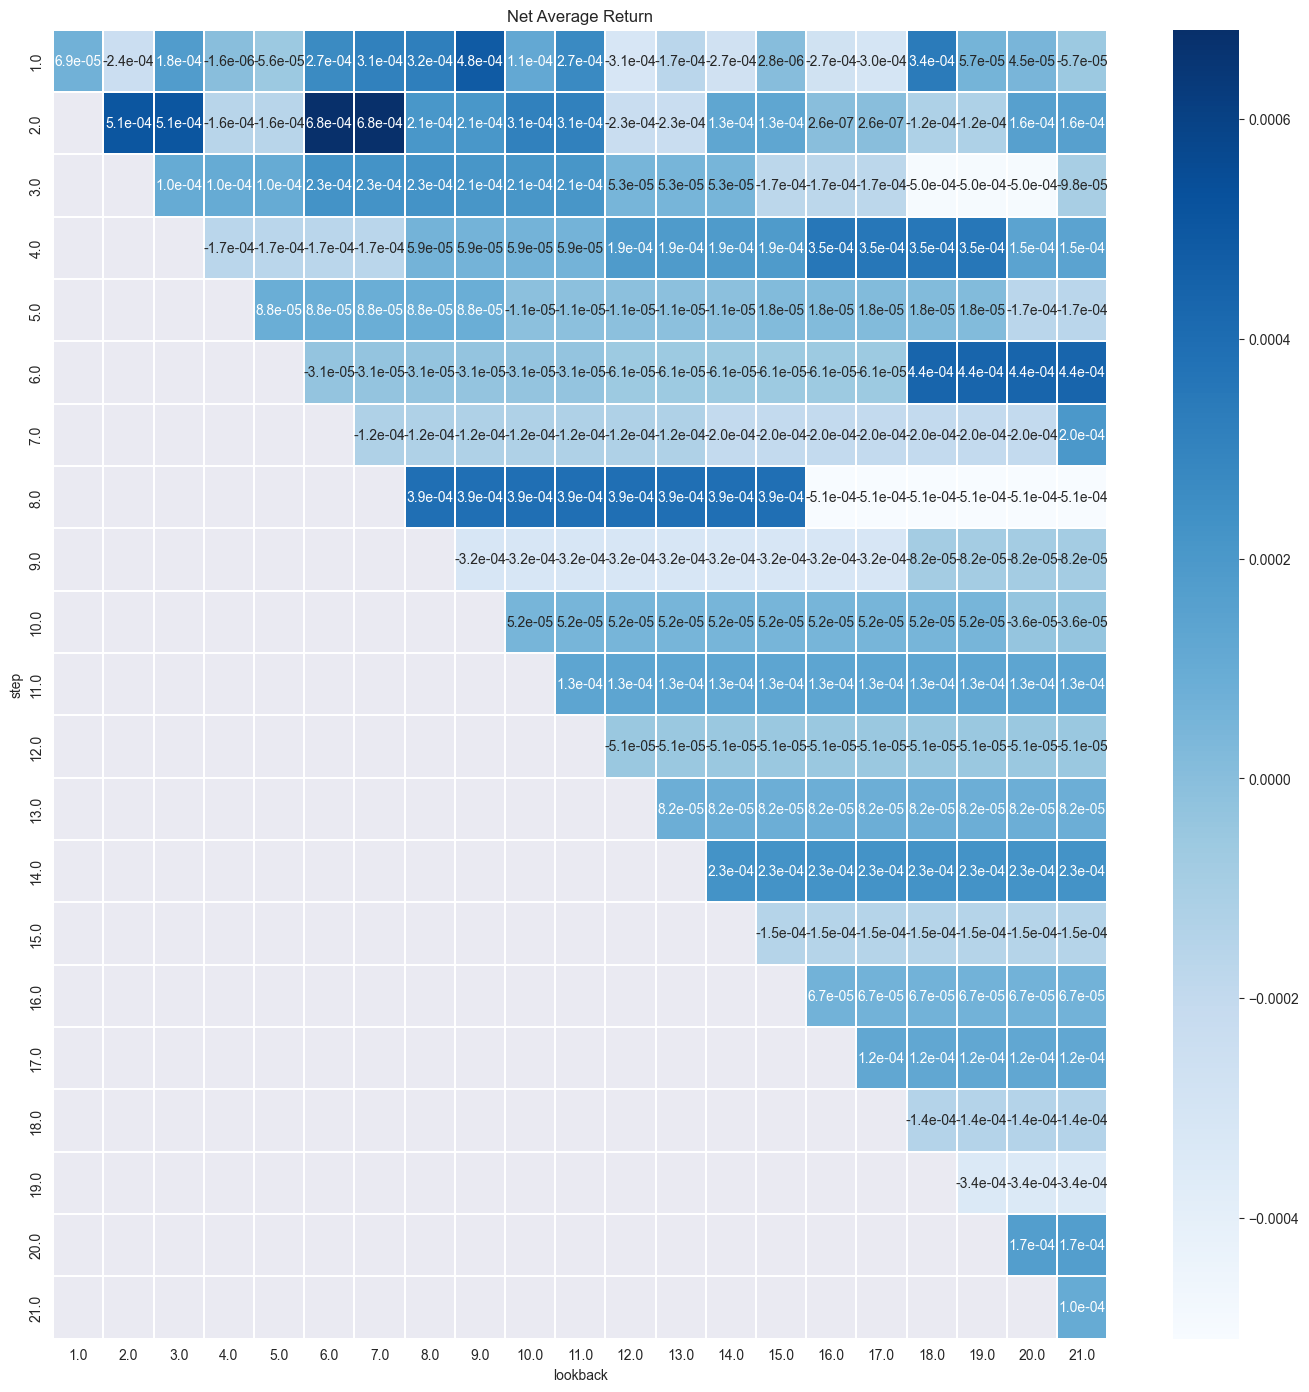

In [8]:
cv_results_formatted = cv_results.pivot(index='step', columns='lookback', values='score')
plt.figure(figsize=(17,17))
sns.heatmap(cv_results_formatted, annot=True, linewidths=.25, cmap='Blues', fmt='.1e')
plt.title('Net Average Return')
plt.show()

We can see a 2 period step interval with a maximum look back of 6 periods performs the best. In the next notebook, we will adjust the parameters of the models

BONUS: Back test best parameters

In [9]:
# !pip3 install backtesting
from backtesting import Strategy, Backtest
from sklearn.model_selection import train_test_split

Loading BokehJS ...

In [10]:
step = 2
lookback = 6

spy = yf.download('SPY', start='2004-12-01')
agg = yf.download('AGG', start='2004-12-01')
gld = yf.download('GLD', start='2004-12-01')

spy = create_target(spy, lookforward, target='Close')

spy = features(spy, lookback, step)
spy = spy.add_suffix(' SPY')
agg = features(agg, lookback, step)
agg = agg.add_suffix(' AGG')
gld = features(gld, lookback, step)
gld = gld.add_suffix(' GLD')
cv = pd.concat([spy, agg, gld], axis=1)

cv.drop(cv.tail(lookforward).index, inplace=True)
cv.drop(cv.head(max(lookbacks)).index, inplace=True)
X = cv
y = X[['Target SPY']]
X = X.drop(columns=['Target SPY'])
X.fillna(method="ffill", inplace=True)
X.replace([np.inf, -np.inf], 0, inplace=True)
X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.825, shuffle=False)
X_test = X_test.iloc[(abs(lookforward)):]
y_test = y_test.iloc[(abs(lookforward)):]

estimator.fit(X_train, y_train)
forecasted = estimator.predict(X_test)
# # flip sign of forecasted values
# forecasted = forecasted * -1

data = yf.download('SPY', start='2004-12-01')
data.drop(data.tail(lookforward).index,inplace=True)
data.drop(data.head(lookback).index,inplace=True)
data = data.iloc[(-X_test.shape[0]):]
data['forecastedValue'] = forecasted
prediction = data

class MyStrategy(Strategy):
    Data = prediction

    def init(self):
        super().init()

    def next(self):
        if self.data.forecastedValue < 0:
            self.sell()
        elif self.data.forecastedValue > 0:
            self.buy()


bt = Backtest(prediction, MyStrategy,
              cash=1000,
              trade_on_close=True,
              exclusive_orders=True
              )
print(bt.run())
bt.plot(show_legend=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Start                     2020-03-19 00:00...
End                       2023-06-07 00:00...
Duration                   1175 days 00:00:00
Exposure Time [%]                   99.753391
Equity Final [$]                  2077.212372
Equity Peak [$]                   2099.320679
Return [%]                         107.721237
Buy & Hold Return [%]               77.352292
Return (Ann.) [%]                   25.501826
Volatility (Ann.) [%]               23.454909
Sharpe Ratio                          1.08727
Sortino Ratio                        2.144782
Calmar Ratio                         1.461032
Max. Drawdown [%]                   -17.45467
Avg. Drawdown [%]                   -2.455774
Max. Drawdown Duration      483 da

Row(id='1408', ...)

Before we evaluate the results, one thing to mention is that the result from this back test is cheating a little bit, since we evaluated this data when we used TimeSeriesSplit. In order to make sure what we have is a real strategy, we need to remove the amount we are going to back test first, lets say 15%, and then cross validate using TimeSeriesSplit with the rest 85%, this way, our model has no way to cheat since it hasn't seen the last 15%.

Onto the results, they seem to be great, but like we pointed out before, the model cheated a little bit, so in the next notebook we will take that into account and test it again after we optimize the parameters on the models and see how well it performs then.